In [ ]:
# Read -
# https://neptune.ai/blog/select-model-for-time-series-prediction-task#:~:text=The%20first%20specificity%20of%20time,are%20specific%20to%20time%20series.
# https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/

In [913]:
!pip install pmdarima

In [914]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [915]:
import warnings
import itertools
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from   datetime import  datetime, timedelta

import statsmodels.api as sm

plt.rcParams['figure.figsize']=[16,8]
warnings.filterwarnings('ignore')

In [916]:
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

plt.rcParams['figure.figsize']=[16,8]

In [917]:
df = pd.read_csv('/content/drive/MyDrive/Model/MainData.csv')
#df = df.drop(['STATE ID','FABRIC KGS','FABRIC MTRS',	'SOLD KGS',	'SOLD MTRS'], axis=1)
df['TIME ID'] =  pd.to_datetime(df["TIME ID"])
df.sort_values(by='TIME ID', ascending = True, inplace=True)
df = df.set_index('TIME ID')
df.head()

,ITEM ID,TIME M ID,TIME Y ID,STATE ID,PARTY ID,FABRIC KGS,FABRIC MTRS,SOLD KGS,SOLD MTRS,RATE,AMOUNT
TIME ID,,,,,,,,,,,
2019-04-01,"60MESHHQ48""WHITE",Apr,2019,GJ,"ENTERPRISE TRADING CO.,",NaN,NaN,70.32,630.0,96.0,30510.0
2019-04-01,"LOTUS54""MARINABLUE",Apr,2019,WB,"SHEW PRATAP NATHMULL Co.,",531.4,10300.0,207.73,4000.0,24.0,48000.0
2019-04-01,"20MESHMQ84""ORANGE",Apr,2019,TN,ANNAI AGENCY,NaN,NaN,9.00,60.0,45.0,2700.0
2019-04-01,"40MESHLQ42""WHITE",Apr,2019,GJ,BARDOLIWAL TRADERS,722.9,10980.0,641.50,9600.0,201.0,187500.0
2019-04-01,"20MESHMQ42""BLACK",Apr,2019,OD,PATRA ENTERPRISES,NaN,NaN,527.40,6000.0,32.0,96000.0


In [918]:
##https://www.section.io/engineering-education/missing-values-in-time-series/

In [919]:
#Missing values
print(df.isnull().sum())

# Treat empty values with UNKNOWN String
df['PARTY ID'] = df['PARTY ID'].replace(to_replace=np.nan, value='UNKNOWN PARTY')
df['STATE ID'] = df['STATE ID'].replace(to_replace=np.nan, value='UNKNOWN STATE')
df.isnull().sum()
print("\nAfter")
print(df.isnull().sum())
df.head()

ITEM ID           0
TIME M ID         0
TIME Y ID         0
STATE ID        765
PARTY ID        765
FABRIC KGS     2620
FABRIC MTRS    2620
SOLD KGS        765
SOLD MTRS       765
RATE            765
AMOUNT          765
dtype: int64

After
ITEM ID           0
TIME M ID         0
TIME Y ID         0
STATE ID          0
PARTY ID          0
FABRIC KGS     2620
FABRIC MTRS    2620
SOLD KGS        765
SOLD MTRS       765
RATE            765
AMOUNT          765
dtype: int64


,ITEM ID,TIME M ID,TIME Y ID,STATE ID,PARTY ID,FABRIC KGS,FABRIC MTRS,SOLD KGS,SOLD MTRS,RATE,AMOUNT
TIME ID,,,,,,,,,,,
2019-04-01,"60MESHHQ48""WHITE",Apr,2019,GJ,"ENTERPRISE TRADING CO.,",NaN,NaN,70.32,630.0,96.0,30510.0
2019-04-01,"LOTUS54""MARINABLUE",Apr,2019,WB,"SHEW PRATAP NATHMULL Co.,",531.4,10300.0,207.73,4000.0,24.0,48000.0
2019-04-01,"20MESHMQ84""ORANGE",Apr,2019,TN,ANNAI AGENCY,NaN,NaN,9.00,60.0,45.0,2700.0
2019-04-01,"40MESHLQ42""WHITE",Apr,2019,GJ,BARDOLIWAL TRADERS,722.9,10980.0,641.50,9600.0,201.0,187500.0
2019-04-01,"20MESHMQ42""BLACK",Apr,2019,OD,PATRA ENTERPRISES,NaN,NaN,527.40,6000.0,32.0,96000.0


In [920]:
df['PARTY ID'].unique()

array(['ENTERPRISE  TRADING CO.,', 'SHEW PRATAP NATHMULL Co.,',
       'ANNAI AGENCY', 'BARDOLIWAL TRADERS', 'PATRA ENTERPRISES',
       'ANANTADEB MADANMOHAN & CO.,', 'SONITE CORPORATION',
       'NANDI POLYMERS', 'SRI BALAJI TRADING CO.,', 'GAYATHRI AGENCIES',
       'ROYAL SALES', 'ANJAN AGENCIES', 'A.R.TRADERS',
       'PEEKAY ENTERPRISES', 'UNKNOWN PARTY', 'VISHNU METAL FINISHERS',
       'FAIR DEAL TRADERS', 'V.N.METAL FINISHERS',
       'HIREN TRADING CO. - UJALA CIRCLE',
       'ASHOK HARDWARE & ALLIED PRODUCTS', 'SUDHARSHAN PLASTIC COMPANY',
       'SIRAJ BARDANA STORE', 'AGRO SHADE NETS', 'FRESH PICK FARMS',
       'JAYKAY AQUA TECH', 'DURGA KARTIKEYA GENERAL STORES',
       'SRI VENKATESHWARA FIBRE UDYOG PVT LTD.', 'SRINIVASA NYLON NETS',
       'RAGHUNATH AGARWALA', 'POLASANAPALLI & CO.,',
       'Ashok Agro Agencies', 'Shree Palathu Karuppana Swamy Trust',
       'Shubham Sales', 'BALAJI TEXTILE', 'LUCKY AGRO AGENCIES',
       'MTR Foods Private Limited', 'MTR Foods Privat

In [921]:
#The data is with respect to each party, itemID, so forecasting the price for only one party
df_m = df.drop(['TIME M ID','TIME Y ID'], axis=1)
df_m = df_m.loc[df['PARTY ID'] == 'SHEW PRATAP NATHMULL Co.,']
#df_m = df_m.loc[df['PARTY ID'] == 'ENTERPRISE  TRADING CO.,']
#df_m = df_m.loc[df['PARTY ID'] == 'SRILAL PACHISIA & Co.,']
#df_m = df_m.loc[df['PARTY ID'] == 'SRI VENKATESHWARA FIBRE UDYOG PVT LTD.']
df_m.head()

,ITEM ID,STATE ID,PARTY ID,FABRIC KGS,FABRIC MTRS,SOLD KGS,SOLD MTRS,RATE,AMOUNT
TIME ID,,,,,,,,,
2019-04-01,"LOTUS54""MARINABLUE",WB,"SHEW PRATAP NATHMULL Co.,",531.4,10300.0,207.73,4000.0,24.0,48000.0
2019-04-01,"HF54""V/IV",WB,"SHEW PRATAP NATHMULL Co.,",NaN,NaN,26.14,600.0,20.0,6000.0
2019-04-01,"KANGAROO84""BLUE",WB,"SHEW PRATAP NATHMULL Co.,",NaN,NaN,316.42,2500.0,65.0,79500.0
2019-04-01,"PF54""LSG",WB,"SHEW PRATAP NATHMULL Co.,",NaN,NaN,332.69,4500.0,33.0,74250.0
2019-04-01,"30MESHLQ42""GREEN",WB,"SHEW PRATAP NATHMULL Co.,",NaN,NaN,888.61,18000.0,91.0,234000.0


In [922]:
df_m['FABRIC KGS'].interpolate(method='linear', inplace=True)
df_m['FABRIC MTRS'].interpolate(method='linear', inplace=True)
df_m['SOLD KGS'].interpolate(method='linear', inplace=True)
df_m['SOLD MTRS'].interpolate(method='linear', inplace=True)
df_m['RATE'].interpolate(method='linear', inplace=True)
df_m['AMOUNT'].interpolate(method='linear', inplace=True)
print(df_m.isnull().sum())
df_m.head()

ITEM ID        0
STATE ID       0
PARTY ID       0
FABRIC KGS     0
FABRIC MTRS    0
SOLD KGS       0
SOLD MTRS      0
RATE           0
AMOUNT         0
dtype: int64


,ITEM ID,STATE ID,PARTY ID,FABRIC KGS,FABRIC MTRS,SOLD KGS,SOLD MTRS,RATE,AMOUNT
TIME ID,,,,,,,,,
2019-04-01,"LOTUS54""MARINABLUE",WB,"SHEW PRATAP NATHMULL Co.,",531.40,10300.0,207.73,4000.0,24.0,48000.0
2019-04-01,"HF54""V/IV",WB,"SHEW PRATAP NATHMULL Co.,",474.26,9510.0,26.14,600.0,20.0,6000.0
2019-04-01,"KANGAROO84""BLUE",WB,"SHEW PRATAP NATHMULL Co.,",417.12,8720.0,316.42,2500.0,65.0,79500.0
2019-04-01,"PF54""LSG",WB,"SHEW PRATAP NATHMULL Co.,",359.98,7930.0,332.69,4500.0,33.0,74250.0
2019-04-01,"30MESHLQ42""GREEN",WB,"SHEW PRATAP NATHMULL Co.,",302.84,7140.0,888.61,18000.0,91.0,234000.0


In [923]:
#https://stackoverflow.com/questions/35628291/how-can-you-interpolate-nan-values-if-first-few-rows-have-nan-values
df_m['FABRIC KGS'].interpolate(method='bfill', inplace=True)
df_m['FABRIC MTRS'].interpolate(method='bfill', inplace=True)
print(df_m.isnull().sum())
#df_m.head()

ITEM ID        0
STATE ID       0
PARTY ID       0
FABRIC KGS     0
FABRIC MTRS    0
SOLD KGS       0
SOLD MTRS      0
RATE           0
AMOUNT         0
dtype: int64


FABRIC KGS     0
FABRIC MTRS    0
SOLD KGS       0
SOLD MTRS      0
RATE           0
AMOUNT         0
dtype: int64


array([<Axes: xlabel='TIME ID'>, <Axes: xlabel='TIME ID'>,
       <Axes: xlabel='TIME ID'>, <Axes: xlabel='TIME ID'>,
       <Axes: xlabel='TIME ID'>, <Axes: xlabel='TIME ID'>], dtype=object)

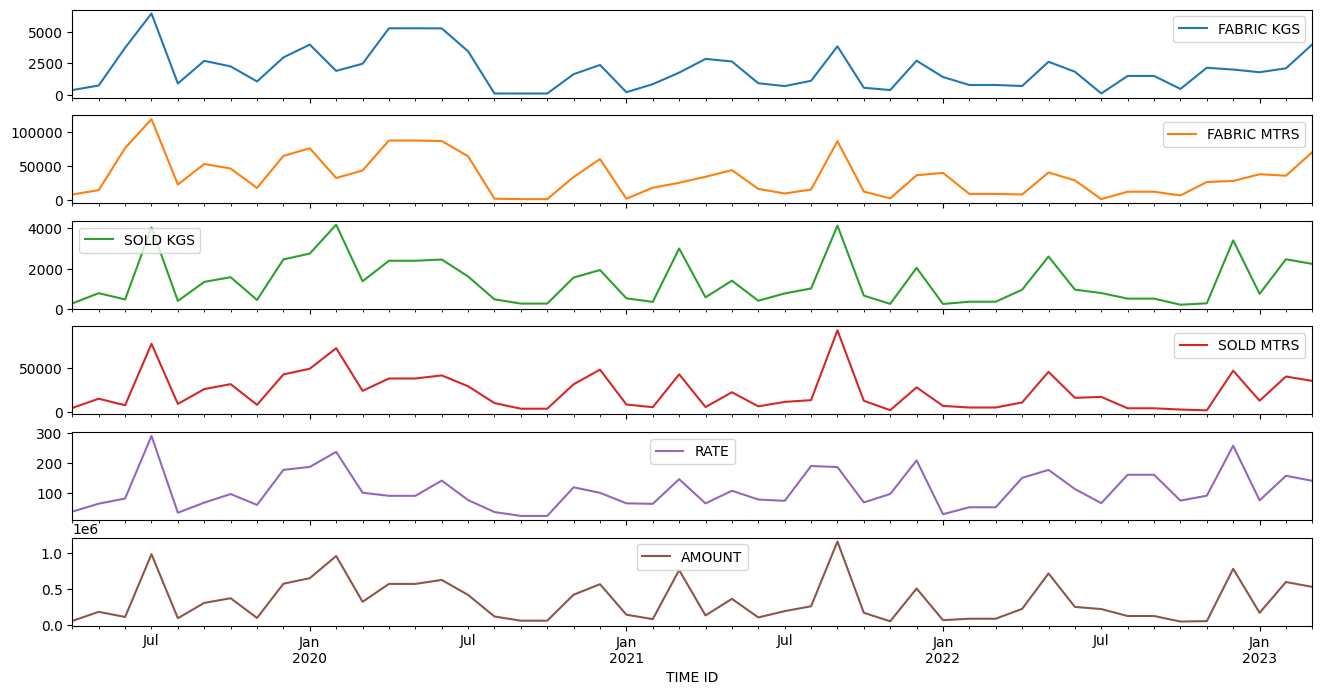

In [924]:
#from sklearn.preprocessing import StandardScaler
#df_m[['RATE', 'AMOUNT']] = StandardScaler().fit_transform(df_m[['RATE', 'AMOUNT']])

df_m = df_m[['FABRIC KGS', 'FABRIC MTRS','SOLD KGS','SOLD MTRS','RATE',	'AMOUNT']]
df_s = df_m.resample('M').mean()
df_s['FABRIC KGS'].interpolate(method='bfill', inplace=True)
df_s['FABRIC MTRS'].interpolate(method='bfill', inplace=True)
df_s['SOLD KGS'].interpolate(method='bfill', inplace=True)
df_s['SOLD MTRS'].interpolate(method='bfill', inplace=True)
df_s['RATE'].interpolate(method='bfill', inplace=True)
df_s['AMOUNT'].interpolate(method='bfill', inplace=True)

print(df_s.isnull().sum())
df_s.plot(subplots=True)

In [925]:
#Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in df_s.iteritems():
    adfuller_test(column, name=column.name)

 FABRIC KGS : P-Value = 0.0 => Stationary. 
 FABRIC MTRS : P-Value = 0.0 => Stationary. 
 SOLD KGS : P-Value = 0.0 => Stationary. 
 SOLD MTRS : P-Value = 0.0 => Stationary. 
 RATE : P-Value = 0.0 => Stationary. 
 AMOUNT : P-Value = 0.0 => Stationary. 


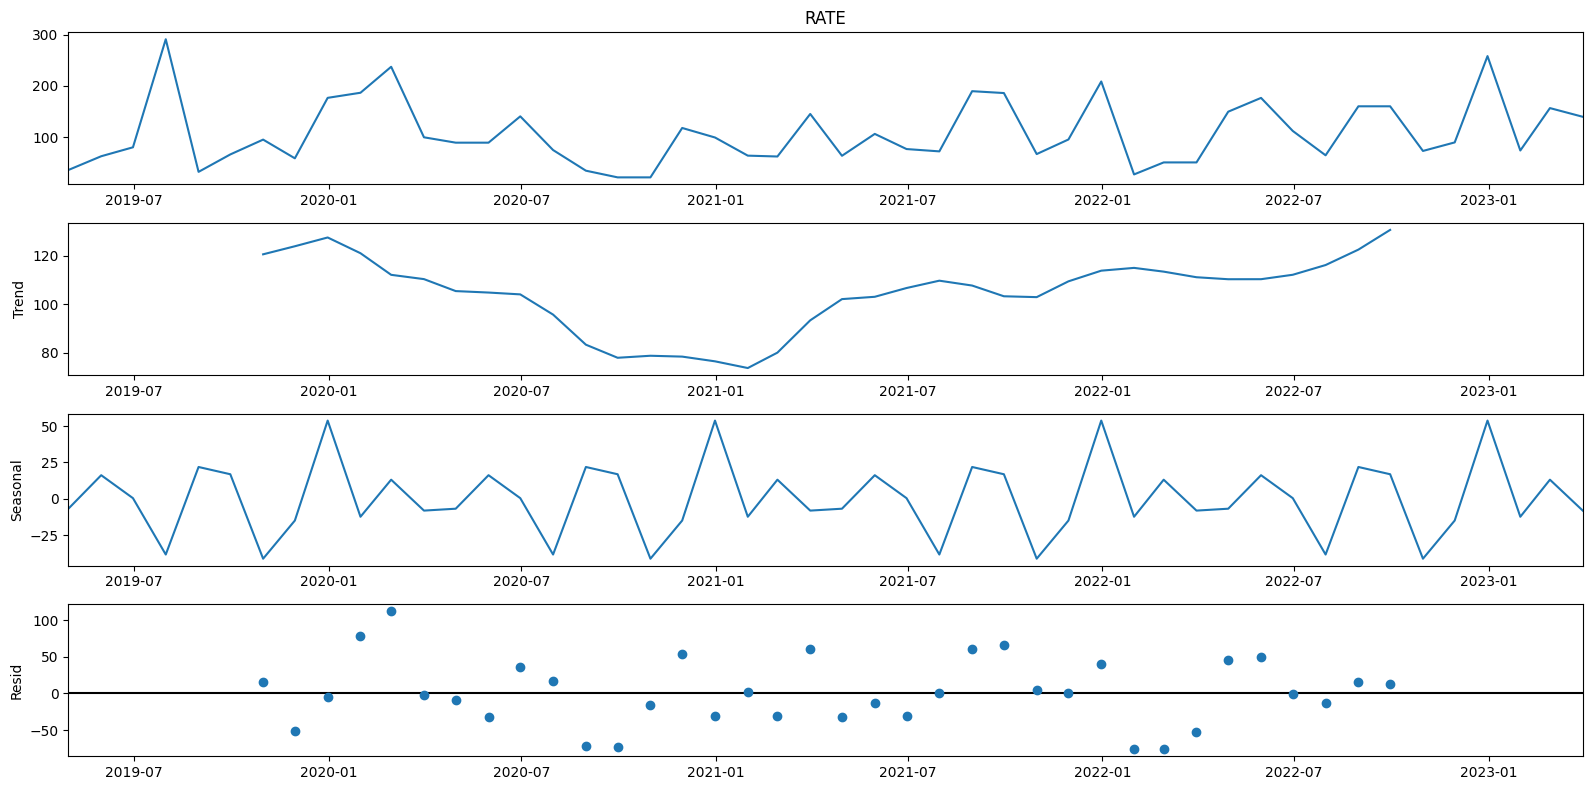

In [926]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_s['RATE'])
result.plot();

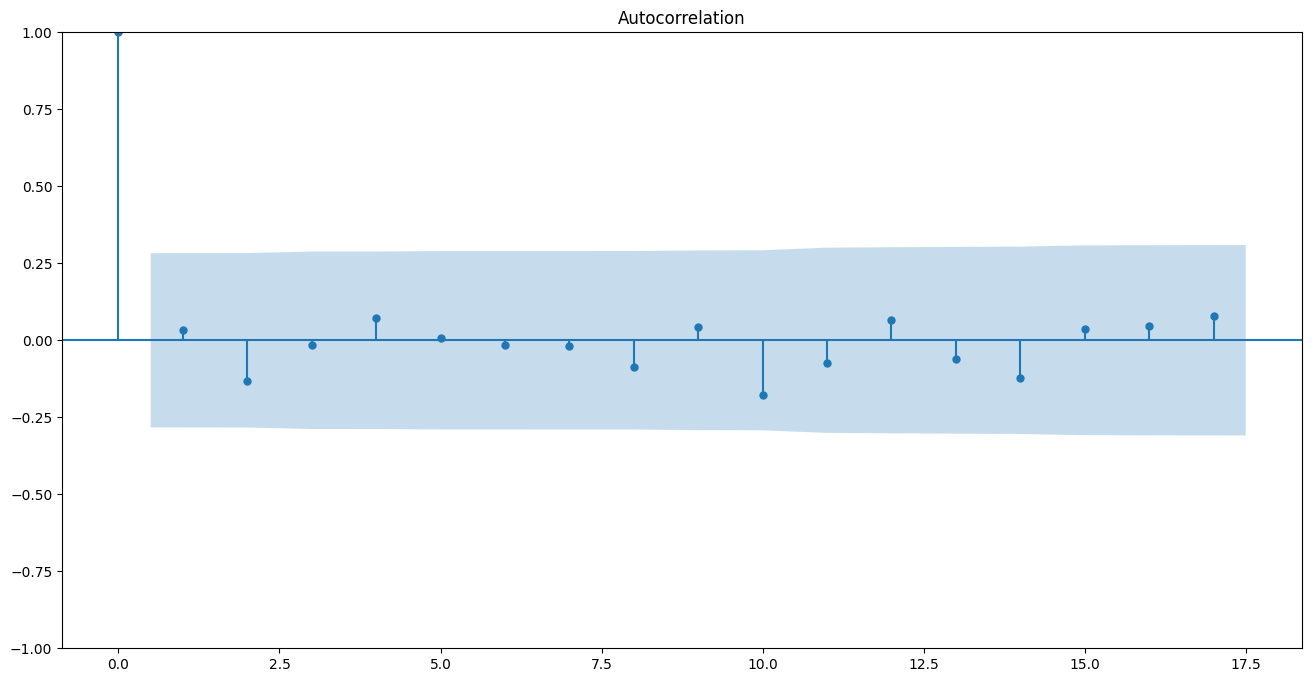

In [927]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_s['RATE']);

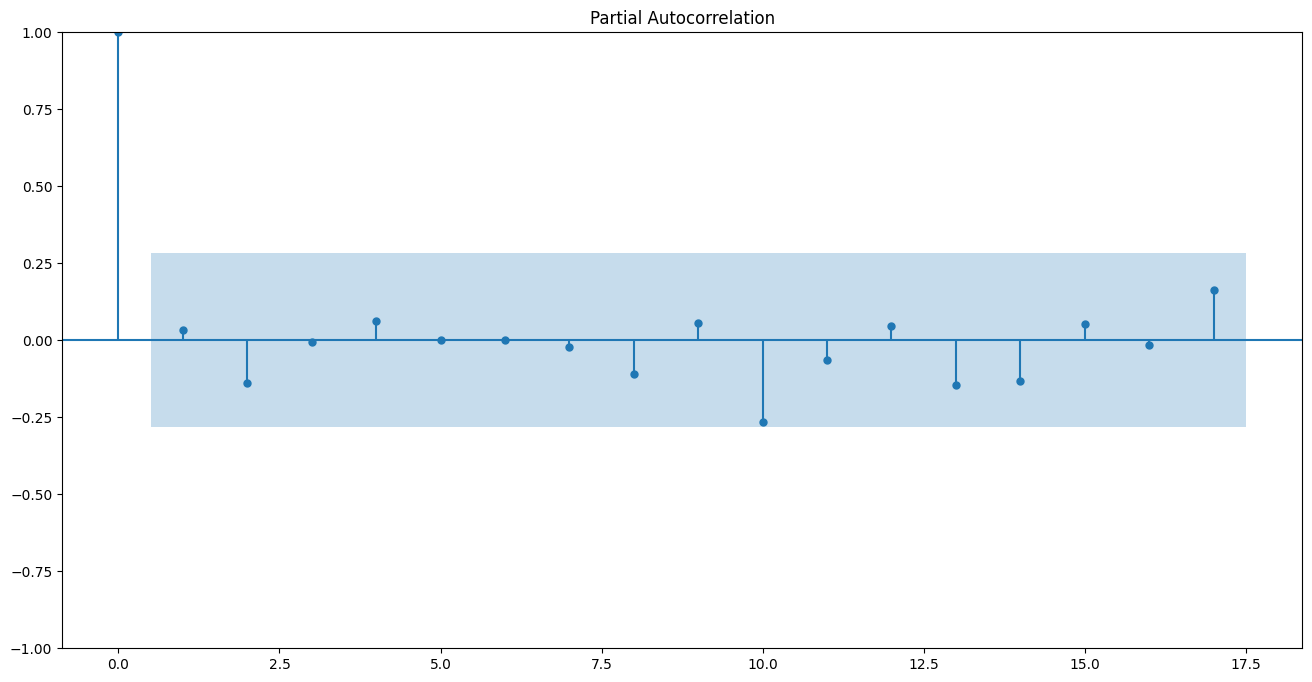

In [928]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_s['RATE']);

In [929]:
# https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
#https://pypi.org/project/pmdarima/
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

#!pip install pmdarima

In [930]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [931]:
train=df_s[(df_s.index.get_level_values(0) >= '2019-04-01') & (df_s.index.get_level_values(0) <= '2022-08-01')]
test=df_s[(df_s.index.get_level_values(0) > '2022-08-01')]
test

,FABRIC KGS,FABRIC MTRS,SOLD KGS,SOLD MTRS,RATE,AMOUNT
TIME ID,,,,,,
2022-08-31,1505.300000,12213.000000,497.250000,4000.000000,160.000000,130000.000000
2022-09-30,1505.300000,12213.000000,497.250000,4000.000000,160.000000,130000.000000
2022-10-31,474.600000,6765.000000,193.126667,2533.333333,72.833333,54216.666667
2022-11-30,2155.150000,26350.000000,265.000000,1650.000000,89.500000,59700.000000
2022-12-31,2014.133333,27910.000000,3407.243333,47250.000000,258.000000,779500.000000
2023-01-31,1801.100000,37749.357143,736.148143,12698.571429,73.714286,174154.285714
2023-02-28,2111.625000,35605.916667,2462.832667,40508.333333,156.508333,597379.166667
2023-03-31,4015.842857,70023.214286,2231.067357,35495.000000,139.535714,530475.000000


In [932]:
model = pm.auto_arima(train['RATE'],
                      m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=460.898, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=459.294, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=458.901, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=462.264, Time=0.26 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=461.770, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=457.419, Time=0.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=459.004, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=455.558, Time=0.27 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=457.027, Time=0.71 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=456.606, Time=0.42 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=453.46

In [933]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   40
Model:             SARIMAX(4, 1, 0)x(0, 0, [1], 12)   Log Likelihood                -219.095
Date:                              Wed, 19 Jul 2023   AIC                            450.190
Time:                                      05:10:29   BIC                            460.171
Sample:                                  04-30-2019   HQIC                           453.771
                                       - 07-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6434      0.168     -3.838      0.000      -0.972      -0.315
ar.L2         -0.62

In [934]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

<Axes: xlabel='TIME ID'>

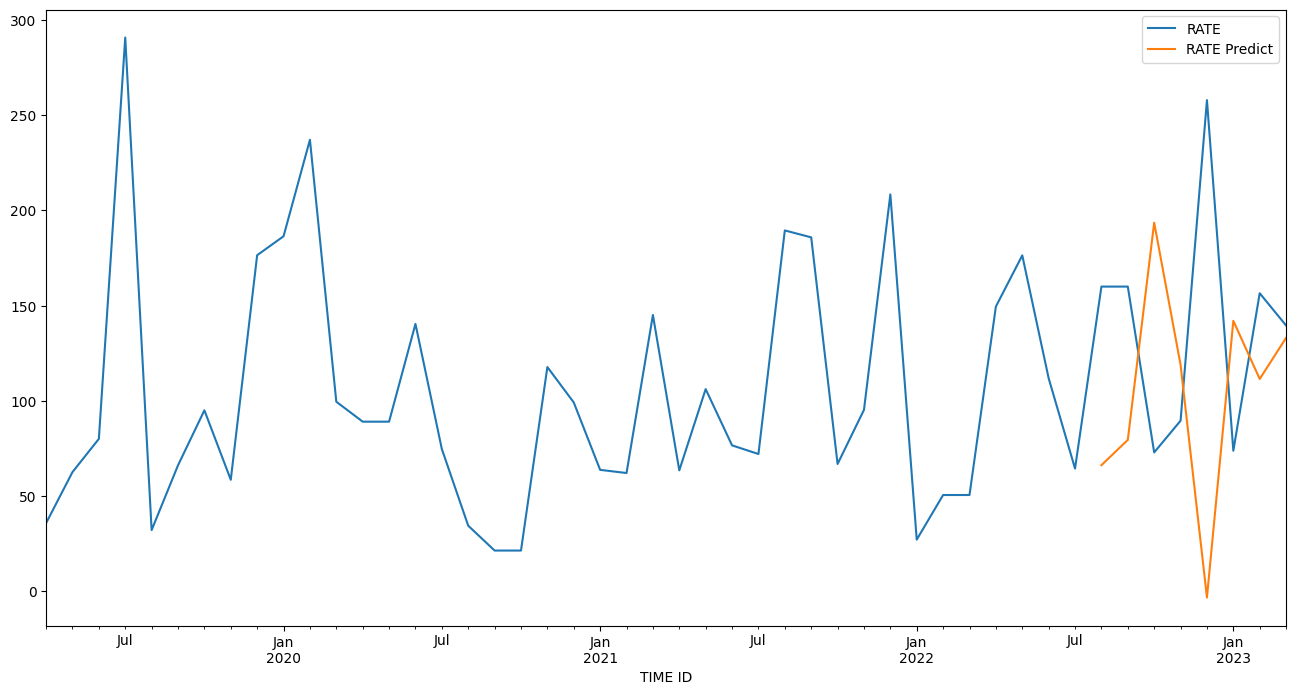

In [935]:
forecast=model.predict(n_periods=8,return_conf_int=True)
forecast_df = pd.DataFrame(forecast[0],index = test.index,columns=['RATE Predict'])
pd.concat([df_s['RATE'],forecast_df],axis=1).plot()

In [936]:
print(pd.DataFrame(dict( rate = test['RATE'].values, rate_predict = forecast_df['RATE Predict'].values)))
print('\n')
print(pd.DataFrame(forecast_accuracy(forecast_df['RATE Predict'].values, test['RATE'].values).items(), columns=['Metrics', 'Value']))

         rate  rate_predict
0  160.000000     66.125600
1  160.000000     79.420118
2   72.833333    193.595924
3   89.500000    118.891384
4  258.000000     -3.440056
5   73.714286    142.004587
6  156.508333    111.441005
7  139.535714    133.062063


  Metrics       Value
0    mape    0.668863
1      me  -33.623880
2     mae   88.234949
3     mpe    0.059357
4    rmse  115.021964
5    corr   -0.913696
6  minmax    0.473740


<Axes: >

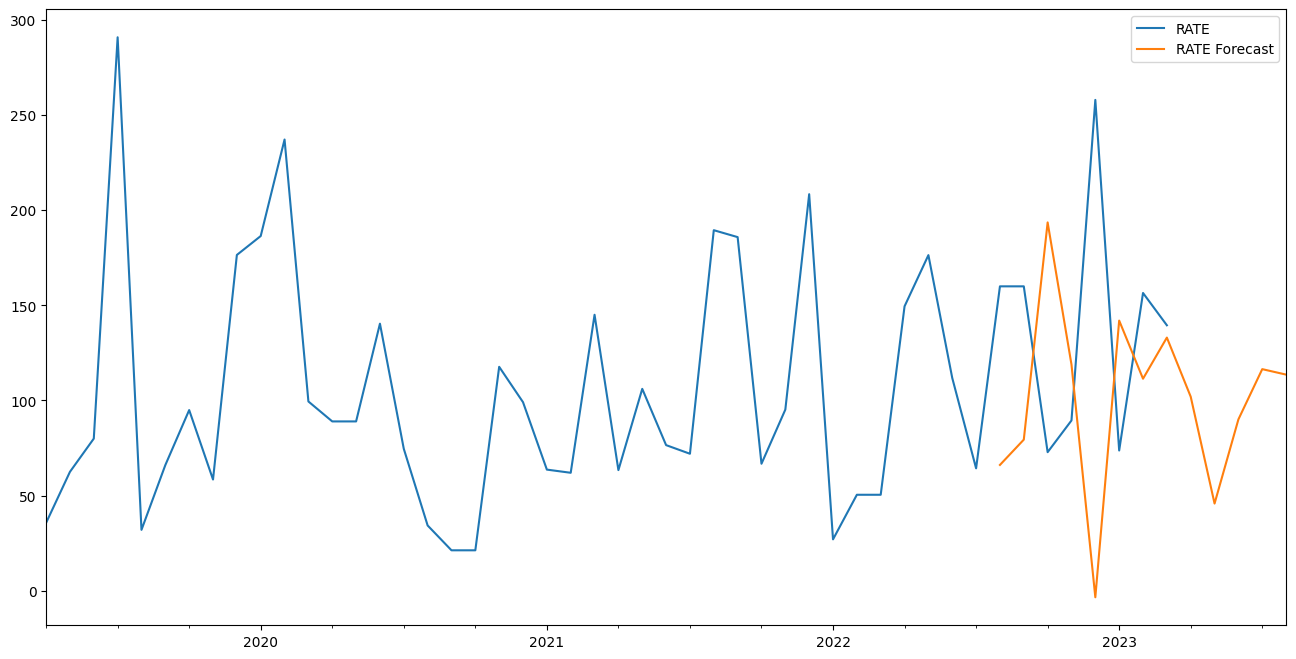

In [937]:
forecast1=model.predict(n_periods=13, return_conf_int=True)
forecast_range=pd.date_range(start='2022-08-01', periods=13,freq='M')
forecast1_df = pd.DataFrame(forecast1[0],index=forecast_range,columns=['RATE Forecast'])
final_df = pd.concat([df_s['RATE'],forecast1_df],axis=1)
final_df.plot()